# Classifying Identifiable People Using Image Classification
Identify whether individuals in an image are "identifiable" or "unidentifiable". Images are considered "identifiable" if they clearly show an individual's face with no obstructions (mask, sunglasses, etc.). An applicaton of this project may be for companies that need to keep track of everyone visiting their locations.

## Building a Classification Model
### Step 1: Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

### Step 2: Load the Data

In [2]:
labels = ['identifiable', 'unidentifiable']
img_size = 224

def get_data(data_dir):
    """Return a numpy array

    Numpy array containing train or testing set data values. Read the images from 
    data_dir in the RGB format and resize the images to the desired width and height.
    """
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label) # 0: identifiable, 1: unidentifiable
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [3]:
# Fetch the train and validation data.
train = get_data('images dataset/Training Set')
val = get_data('images dataset/Testing Set')

### Step 3: Visualize the data

<AxesSubplot:ylabel='count'>

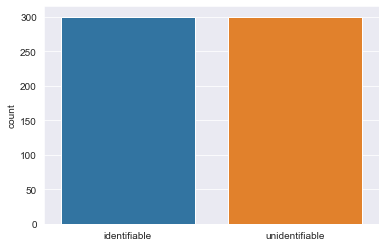

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("identifiable")
    else:
        l.append("unidentifiable")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'identifiable')

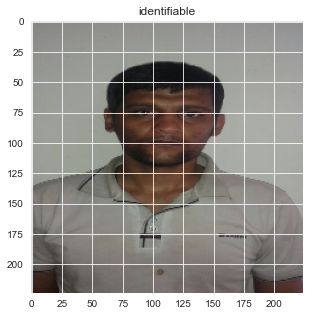

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'unidentifiable')

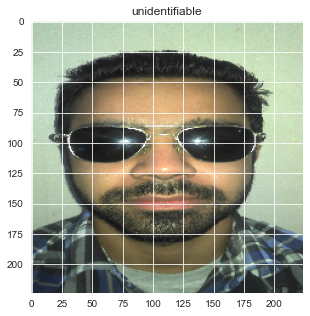

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

### Step 4: Data Preprocessing and Augmentation

In [7]:
# Preprocess the data
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [8]:
# Augment the data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

### Step 5: Define the Model

In [9]:
# Define a simple CNN with 3 Convolutional layers followed by max-pooling layers. 
#   A dropout layer is added after the 3rd maxpool operation to avoid overfitting.
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [10]:
# Compile the model using the Adam optimizer.
#   SparseCategoricalCrossentropy is the loss function.
#   Use a lower learning rate of 0.000001 for a smoother curve.
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [11]:
# epochs represent the number of times the model goes through the training set.
#   The model can be updated multiple times during one epoch.
#   Train the model for 500 epochs because the learning rate is so small.
#      500 epochs will produce a runtime of nearly 4 hours on a local machine.
numEpochs = 5
history = model.fit(x_train,y_train,epochs = numEpochs , validation_data = (x_val, y_val))

Epoch 1/5
19/19 [==============================] - 35s 2s/step - loss: 0.7143 - accuracy: 0.4779 - val_loss: 0.6923 - val_accuracy: 0.5018
Epoch 2/5
19/19 [==============================] - 30s 2s/step - loss: 0.6924 - accuracy: 0.5000 - val_loss: 0.6910 - val_accuracy: 0.5309
Epoch 3/5
19/19 [==============================] - 31s 2s/step - loss: 0.7026 - accuracy: 0.4464 - val_loss: 0.6910 - val_accuracy: 0.5673
Epoch 4/5
19/19 [==============================] - 30s 2s/step - loss: 0.6929 - accuracy: 0.4939 - val_loss: 0.6908 - val_accuracy: 0.5636
Epoch 5/5
19/19 [==============================] - 30s 2s/step - loss: 0.6897 - accuracy: 0.5602 - val_loss: 0.6909 - val_accuracy: 0.5345


### Step 6: Evaluate the Model

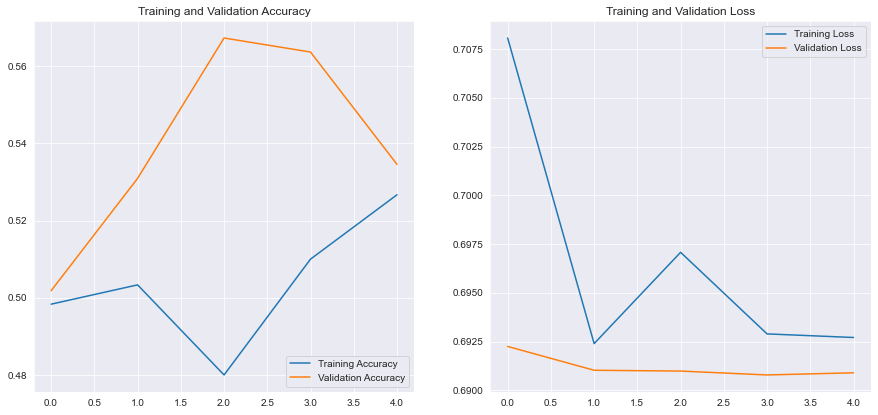

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range is 5 beacause the previous step used 5 epochs
epochs_range = range(numEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( epochs_range, acc, label='Training Accuracy')
plt.plot( epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# predictions = model.predict_classes(x_val)
# above line is soon to be deprecated, is replaced with line below
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Identifiable (Class 0)','Unidentifiable (Class 1)']))

                          precision    recall  f1-score   support

  Identifiable (Class 0)       0.52      0.93      0.67       137
Unidentifiable (Class 1)       0.68      0.14      0.23       138

                accuracy                           0.53       275
               macro avg       0.60      0.54      0.45       275
            weighted avg       0.60      0.53      0.45       275



## Implementing a Pre-Trained Model
### Step 1: Import the Model

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False,
                                               weights = "imagenet")

In [15]:
base_model.trainable = False

In [16]:
# Line Changed: tf.keras.layers.Dense(2, activation="softmax")
#   Adds a final dense layer with 2 neurons and softmax activation.
#   This led to a ValueError when calling model.fit(...):
#      ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
#   Possible solution involves changing the dimensions of x_train, y_train, x_val, and/or y_val.
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(1, activation="softmax")                                     
                                ])

In [17]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs = numEpochs , validation_data = (x_val, y_val))

Epoch 1/5
19/19 [==============================] - 35s 2s/step - loss: 0.7083 - accuracy: 0.4774 - val_loss: 0.6863 - val_accuracy: 0.5018
Epoch 2/5
19/19 [==============================] - 30s 2s/step - loss: 0.7069 - accuracy: 0.5254 - val_loss: 0.6777 - val_accuracy: 0.5018
Epoch 3/5
19/19 [==============================] - 32s 2s/step - loss: 0.6848 - accuracy: 0.4986 - val_loss: 0.6692 - val_accuracy: 0.5018
Epoch 4/5
19/19 [==============================] - 27s 1s/step - loss: 0.6874 - accuracy: 0.4878 - val_loss: 0.6609 - val_accuracy: 0.5018
Epoch 5/5
19/19 [==============================] - 27s 1s/step - loss: 0.6695 - accuracy: 0.4841 - val_loss: 0.6532 - val_accuracy: 0.5018
